In [12]:
# import autograd.numpy as np
import numpy as np
from pymanopt.manifolds import Stiefel, Sphere
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent
from geomstats.geometry.hypersphere import Hypersphere
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import geomstats.backend as gs

gs.random.seed(2020)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 12)

# Setting up the Hypersphere

In [13]:
# Sampling Hypersphere
n_samples=1000
dim = 2
sphere = Hypersphere(dim=dim)
points_in_manifold = sphere.random_uniform(n_samples)

In [14]:
# Creating Initial Point and Tangent Vector
x_0 = points_in_manifold[0,:]
vector = gs.array([1, 0, 1])
tangent_vector = sphere.to_tangent(vector, base_point=x_0)

print(f'Starting Point on manifold: {x_0}')
print(f'Tangent Vector: {tangent_vector}')

Starting Point on manifold: [-0.84203574  0.03596567 -0.5382214 ]
Tangent Vector: [-0.16222585  0.04964187  0.25711606]


In [15]:
# Wireframe for Sphere Surface
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)

#https://stackoverflow.com/questions/11140163/plotting-a-3d-cube-a-sphere-and-a-vector-in-matplotlib

Text(0.5, 0.92, 'Hypersphere of Dimension 3')

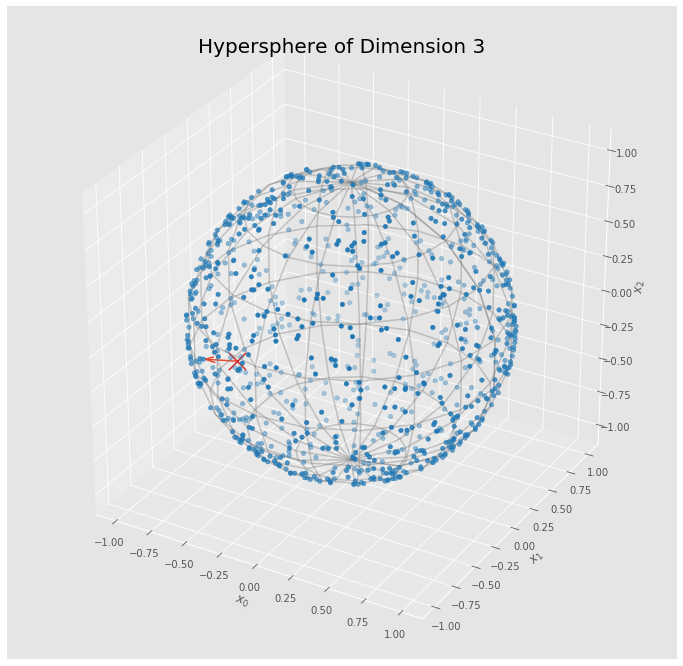

In [16]:
# Plotting Points in 3D
ax = plt.axes(projection='3d')

# Points with first one Highlighted
ax.scatter(points_in_manifold[1:,0],points_in_manifold[1:,1],points_in_manifold[1:,2],color="tab:blue",s=20)
ax.scatter(points_in_manifold[0,0],points_in_manifold[0,1],points_in_manifold[0,2],color="tab:red",s=300, marker="x")

# Tangent Vector
ax.quiver(points_in_manifold[0,0],points_in_manifold[0,1],points_in_manifold[0,2],
          points_in_manifold[0,0] + tangent_vector[0],points_in_manifold[0,1] + tangent_vector[1],points_in_manifold[0,2] + 
          tangent_vector[2], length=0.25)
# Sphere
ax.plot_wireframe(x, y, z, color="grey", alpha=0.4)
ax.set_xlabel(r'$x_0$')
ax.set_ylabel(r'$x_1$')
ax.set_zlabel(r'$x_2$')
ax.set_title(f'Hypersphere of Dimension {dim + 1}', fontsize=20)

In [17]:
def sphere_exp_map(v, x):
    """
    Input: v (tangent vector), x (starting point on manifold)
    Output: ... (point restrained to manifold)
    """
    r = 1 # assuming unit sphere
    ans = x * np.cos(np.linalg.norm(v)/r) + (r*v/np.linalg.norm(v))*np.sin(np.linalg.norm(v)/r)
    return ans

def sphere_R_map(v, x):
    """
    Input: v (tangent vector), x (starting point on manifold)
    Output: ... (point restrained to manifold)
    """
    r = 1 # assuming unit sphere
    num = x + v
    denom = np.linalg.norm(x + v)
    return r * (num / denom)

# https://wiseodd.github.io/techblog/2019/02/22/optimization-riemannian-manifolds/

In [18]:
# Testing Exponential Mapping
x_manifold = sphere_exp_map(tangent_vector, x_0)
x_manifold_geomstats = sphere.metric.exp(tangent_vector, base_point=x_0)

# https://geomstats.github.io/notebooks/02_from_vector_spaces_to_manifolds.html

In [19]:
print(f'Point from our Function: {x_manifold}\nPoint from GeomStats: {x_manifold_geomstats}')

Point from our Function: [-0.96207257  0.08313322 -0.25981771]
Point from GeomStats: [-0.96207257  0.08313322 -0.25981771]


In [20]:
# Testing Retraction Mapping
x_manifold_R = sphere_R_map(tangent_vector, x_0)
x_manifold_geomstats_R = sphere.metric.exp(tangent_vector, base_point=x_0)

In [21]:
x_manifold_R
# Not sure if geomstats has an option for retraction built in for sphere...

array([-0.95975762,  0.08181382, -0.26864813])

# First Order Optimization Methods

## Riemanian Gradient Descent

In [22]:
def RGD(x, lam, M, f, algo=1):
    """
    Input: x (starting point on manifold), lam (step size) IMPLEMENT LINE SEARCH VARIANTS TOO, M (manifold), f (cost function), algo (1 = Retraction, 0 = Exponential Mapping)
    Output: Point on manifold that minimizes cost function
    """
    # 1. Compute Gradient of f at x
    # 2. Move in euclidean direction of neg. gradient * step size
    # 3. Project back onto manifold
    # 4. Update step and repeat

    # 5. Stopping Criteria?

# Second Order Optimization Methods

## Conjugate Gradient Descent

## Trust Regions

In [35]:
import autograd.numpy as np

from pymanopt.manifolds import Stiefel, Sphere
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent

# (1) Instantiate a manifold
manifold = Sphere(2)
x_manifold_pymanopt = manifold.exp(x_0, tangent_vector)
x_manifold_pymanopt_R = manifold.retr(tangent_vector, x_0)

In [38]:
# Check that norm_U isn't too tiny. If very small then
# sin(norm_U) / norm_U ~= 1 and retr is extremely close to exp.
# if norm_U > 1e-3 ... (from source code)
print(f'Confirming Norm is within threshold and is using expoential mapping... Norm(tangent vec): {np.linalg.norm(tangent_vector)}')

# Printing Results
print(f'Point from PyManOpt(exp): {x_manifold_pymanopt}')
print(f'Point from PyManOpt(retraction): {x_manifold_pymanopt_R}')

Confirming Norm is within threshold and is using expoential mapping... Norm(tangent vec): 0.30804254500764416
Point from PyManOpt(exp): [-0.96207257  0.08313322 -0.25981771]
Point from PyManOpt(retraction): [-0.95975762  0.08181382 -0.26864813]


In [39]:
# (2) Define the cost function (here using autograd.numpy)
def cost(X): return np.sum(X)

problem = Problem(manifold=manifold, cost=cost)

# (3) Instantiate a Pymanopt solver
solver = SteepestDescent()

# let Pymanopt do the rest
Xopt = solver.solve(problem)
print(Xopt)

Compiling cost function...
Computing gradient of cost function...
 iter		   cost val	    grad. norm
    1	+1.3406169041345610e+00	4.50273602e-01
    2	+6.2956778676630254e-01	1.26635082e+00
    3	-9.0079020634944196e-01	1.09021879e+00
    4	-1.2312732908974380e+00	6.95676709e-01
    5	-1.3718003638567222e+00	3.43749563e-01
    6	-1.3998695131449703e+00	2.00911289e-01
    7	-1.4022947125929548e+00	1.83219920e-01
    8	-1.4100205384684787e+00	1.08821326e-01
    9	-1.4113160956182549e+00	9.04813696e-02
   10	-1.4141807480888420e+00	9.63388472e-03
   11	-1.4142092143088041e+00	3.50687383e-03
   12	-1.4142117996698764e+00	2.23286240e-03
   13	-1.4142131784404359e+00	1.04207744e-03
   14	-1.4142133193589208e+00	8.29064427e-04
   15	-1.4142135561709601e+00	1.32447299e-04
   16	-1.4142135621415970e+00	2.55885751e-05
   17	-1.4142135622864009e+00	1.56591088e-05
   18	-1.4142135623341447e+00	1.04961097e-05
   19	-1.4142135623711098e+00	2.36959851e-06
   20	-1.4142135623730421e+00	3.88070262e-07


In [40]:
# From Source Code in pymanopt(sphere): https://github.com/pymanopt/pymanopt/blob/master/pymanopt/manifolds/sphere.py

# def exp(self, X, U):
#     norm_U = self.norm(None, U)

#         return X * np.cos(norm_U) + U * np.sin(norm_U) / norm_U
#     else:
#         return self.retr(X, U)